## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist=pd.read_csv("Mnist_combined.csv",index_col=0)

In [5]:
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.shape

(70000, 785)

## 3. Convert the Data into Tensor Dataset

In [7]:
mnist = mnist.sample(20000)

In [8]:
mnist.shape

(20000, 785)

In [9]:
X = mnist.drop(labels = "label" ,axis = 1)

# In this , we actually don't need labels
Y = mnist["label"]

In [10]:
Y.head()

3331     6
31491    6
35913    4
42368    7
7777     8
Name: label, dtype: int64

In [11]:
data_np = X.to_numpy()
labels_np = Y.to_numpy()

In [12]:
data_np[0].shape

(784,)

In [13]:
labels_np.shape

(20000,)

In [14]:
labels_np

array([6, 6, 4, ..., 1, 1, 8], dtype=int64)

In [15]:
#labels_np=labels_np[:,None]

In [16]:
# Normalize the data(predictors) to a range of [0 1]
dataNorm = data_np / np.max(data_np)

In [17]:
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Converting Numpy array to Pytorch Array

In [18]:
# convert to a pytorch tensor
data = torch.tensor(dataNorm).float()

# Note: "long" format for CCE : Multiclass classification
labels = torch.tensor(labels_np).long() 

In [19]:
labels

tensor([6, 6, 4,  ..., 1, 1, 8])

## 4. Demonstration of implementing occlusion

In [20]:
import copy

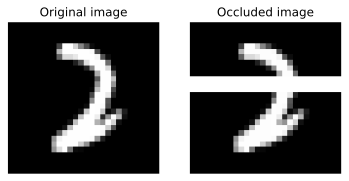

In [21]:
# reconstruct a sample as an image

img = data[12345,:].view(28,28)


occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(6,4))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

## 4. Create and validate the model

In [22]:
# create a class for the model
def createTheMNIST_AE_Net(LR):

    class MNIST_AE_Net(nn.Module):
        
        def __init__(self ):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(784, 128)

            ### Encode Layer
            self.enc = nn.Linear(128,50)
            
            ### Latent layer
            self.lat = nn.Linear(50,128)
            
            ### decoder layer
            self.dec = nn.Linear(128,784)
            

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Encode layer
            x = F.relu( self.enc(x) )
            # latent Layer
            x = F.relu(self.lat(x))
            
            # since, Predictors have range between 0 and 1
            # Therefore, using sigmoid as an activation function
            y = torch.sigmoid(self.dec(x))
            
            return y
        

    # create the model instance
    ANN_AE_model = MNIST_AE_Net( )

    # loss function : Negative Log-Likelihood Loss function
    lossfunc = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(ANN_AE_model.parameters(),lr=LR)

    return ANN_AE_model, lossfunc, optimizer

## 5. Model Training

In [23]:
def function2trainTheModel(Model, lossfunc, optimizer, predictors, epochs):

    # initialize losses
    losses = torch.zeros(epochs)

    # loop over epochs
    for epochi in range(epochs):

        # select a random set of images
        randomidx = np.random.choice(predictors.shape[0],size=32)
        X = predictors[randomidx,:]

        # forward pass and loss
        yHat = Model(X)
        loss = lossfunc(yHat,X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.item()
        # end epochs
        
    #print(losses) 
    #print(torch.mean(losses))
    #print(np.round(torch.mean(losses),3))
    #Final_loss = torch.mean(losses[-3:])
    
    # function output
    #return Final_loss, Model
    return losses, Model

## 6. Experiment

In [24]:
# Create the network
ANN_AEmodel, Lossfunc, Optimizer = createTheMNIST_AE_Net(LR=0.001)

# Model Training
Losses,trained_model =  function2trainTheModel(Model=ANN_AEmodel, 
                                               lossfunc=Lossfunc, 
                                               optimizer=Optimizer, 
                                               predictors=data,
                                               epochs=2000)


#### (a) Visualization : Losses versus epochs 

Final loss: 0.0147


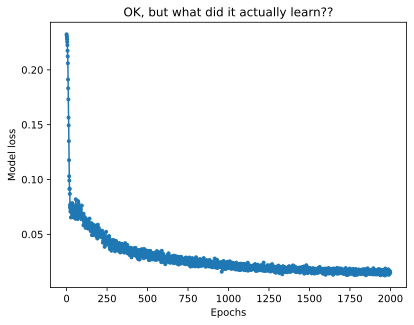

In [25]:
print(f'Final loss: {Losses[-1]:.4f}')

# visualize the losses
plt.plot(Losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')

plt.show()

## 7. Testing :  Add occlusion to some images

In [30]:
# grab a small set of images
X = copy.deepcopy( data[:10,:] )

# add noise
for i in range(X.shape[0]):
  
    # reshape the image
    img = X[i,:].view(28,28)

    # occlude random rows or columns
    startloc = np.random.choice(range(10,21))
    
    if i%2==0: # even -> horizontal occlusion
        img[startloc:startloc+2,:] = 1
    
    else:      # odd -> vertical occlusion
        img[:,startloc:startloc+2] = 1

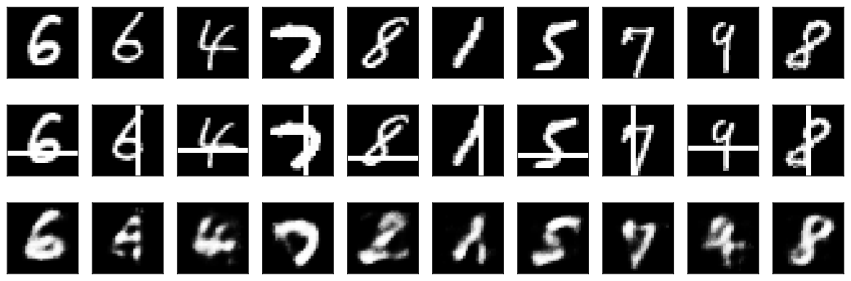

In [31]:
# Run the samples through the model
deOccluded = trained_model(X)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
    
    # Original Images
    axs[0,i].imshow(data[i,:].view(28,28).detach() ,cmap='gray')
    # Occulded Images
    axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
    # Deocculded Images from AE output
    axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
    
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
    axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.show()

## 8. Quantitative Impact of Occlusion on AE output

In [32]:
# Grab a small set of images
X = copy.deepcopy( data[:10,:] )

# Add noise
for i in range(X.shape[0]):
  
    # reshape the image
    img = X[i,:].view(28,28)

    # occlude random rows or columns
    startloc = np.random.choice(range(10,21))
    
    if i%2==0: # even -> horizontal occlusion
        img[startloc:startloc+2,:] = 1
    
    else:      # odd -> vertical occlusion
        img[:,startloc:startloc+2] = 1

In [33]:
# Run the samples through the model
deOccluded = trained_model(X)

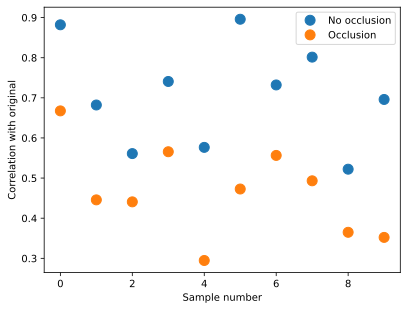

In [35]:
# get data with no occlusion
noOcclusion = trained_model(data[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
tol = 1e-4

for i in range(deOccluded.shape[0]):

    # pixel selection (note: tolerance defined in previous cell)
    nonzeropixels = (data[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

    # now compute the correlations
    r[i,0] = np.corrcoef(data[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
    r[i,1] = np.corrcoef(data[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)

plt.legend(['No occlusion','Occlusion'])

plt.xlabel('Sample number')
plt.ylabel('Correlation with original')

plt.show()